# Librerias

In [35]:
#Importemos las librerias Necesarias:
import scipy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time, random

In [36]:
from sklearn.feature_selection import *
from sklearn.preprocessing import *
from sklearn.metrics import *
from sklearn.tree import *
from sklearn.model_selection import *

***

In [37]:
# Carguemos la infromacion antes de nada:
cols = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'class']

df = pd.read_csv('column_3C.dat', sep=' ', names=cols)
df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.03,22.55,39.61,40.48,98.67,-0.25,DH
1,39.06,10.06,25.02,29.00,114.41,4.56,DH
2,68.83,22.22,50.09,46.61,105.99,-3.53,DH
3,69.30,24.65,44.31,44.64,101.87,11.21,DH
4,49.71,9.65,28.32,40.06,108.17,7.92,DH


## Analicemos la informacion:

In [38]:
df.describe()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496484,17.542903,51.930710,42.953871,117.920548,26.296742
std,17.236109,10.008140,18.553766,13.422748,13.317629,37.558883
min,26.150000,-6.550000,14.000000,13.370000,70.080000,-11.060000
25%,46.432500,10.667500,37.000000,33.347500,110.710000,1.600000
50%,58.690000,16.360000,49.565000,42.405000,118.265000,11.765000
75%,72.880000,22.120000,63.000000,52.692500,125.467500,41.285000
max,129.830000,49.430000,125.740000,121.430000,163.070000,418.540000


De aqui obtenemos que no faltan valores y cierta información estadistica relevante.

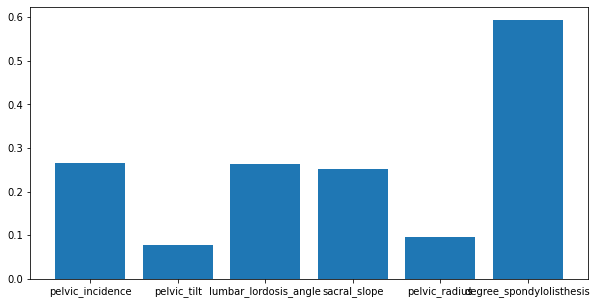

In [39]:
# Veamos si podemos reducir la dimensaionalidad pese a que en este caso no seria preciso:
seed = random.seed(time.time())

X = df.drop(cols[-1], axis=1)
y = df[cols[-1]]
cls = mutual_info_classif(X, y, random_state=seed)

plt.figure(figsize=(10,5))
plt.bar(cols[:-1], cls)
plt.show()

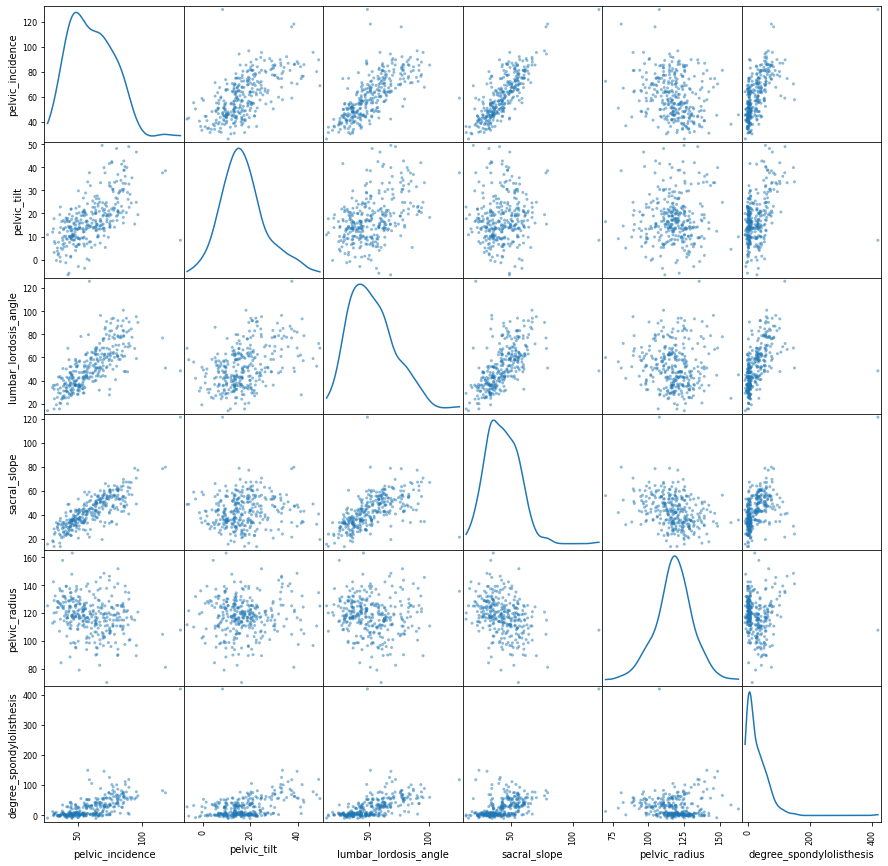

In [40]:
# analicemos si existen outlayers y su numero:
matrix = pd.plotting.scatter_matrix(df, alpha=0.5, figsize=(15, 15), diagonal='kde')

Derivado de la función .descrive() sabemos que convendria realizar un escalado de los datos a fin de establecer la misma escala para todas las variables.
Y derivado del conjunto de gráficos de la celda superior podemos establecer el modelo mas conveniente a usar ya que se ve que, aunque no sean demasiados, existen los outliers.
Por tanto, emplearemos el robust scaller:

In [41]:
# Adecuemos el DF
scl_df = df.drop(cols[-1], axis=1)

# Creamos el objeto y transformamos los datos:
scl_model = RobustScaler()
scl_model.fit(scl_df)
scl_df = scl_model.transform(scl_df)

# Adecuamos los datos 
scl_df = pd.DataFrame(scl_df, columns=cols[:-1])
df = pd.concat((scl_df, df[cols[-1]]), axis=1)
df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,0.164099,0.540493,-0.382885,-0.099509,-1.327799,-0.302759,DH
1,-0.742225,-0.550098,-0.944038,-0.692944,-0.261223,-0.181555,DH
2,0.383401,0.511679,0.020192,0.217369,-0.831780,-0.385410,DH
3,0.401172,0.723859,-0.202115,0.115534,-1.110961,-0.013985,DH
4,-0.339541,-0.585898,-0.817115,-0.121220,-0.684059,-0.096888,DH


Veamos el resultado del escalado:

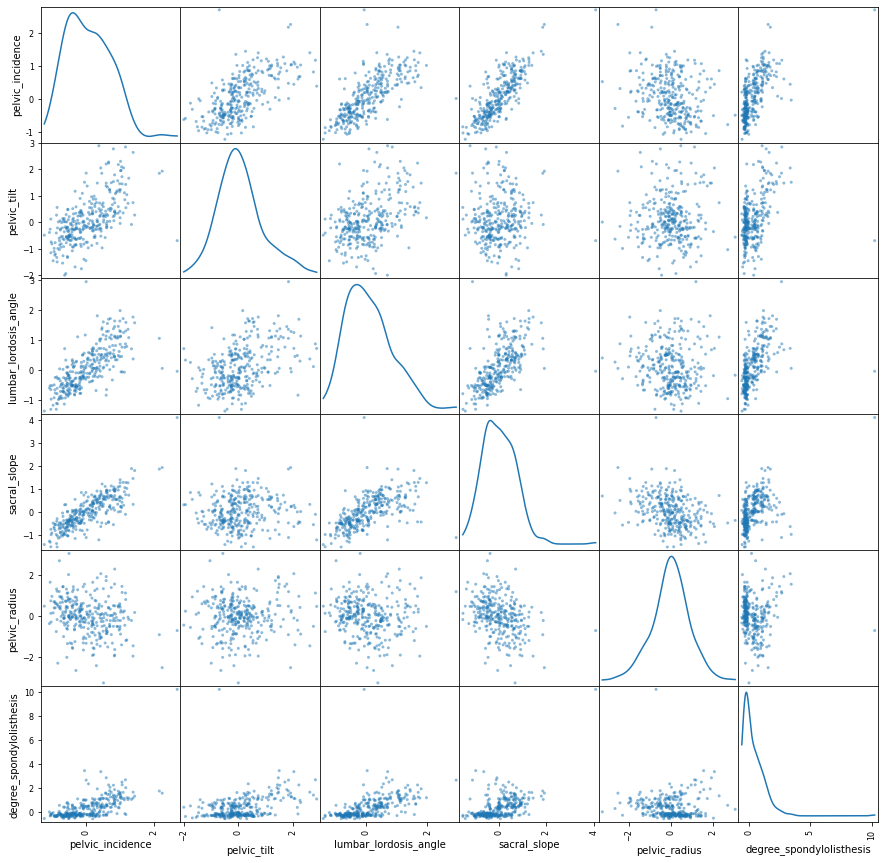

In [42]:
matrix = pd.plotting.scatter_matrix(df, alpha=0.5, figsize=(15, 15), diagonal='kde')

### Pasemos a entrenar el modelo:

In [43]:
# Partamos el df en test y train:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(cols[-1], axis=1),
    df[cols[-1]],
    test_size=0.3,
    random_state=random.seed(time.time()) 
)

In [44]:
# creemos y entrenemos el modelo:
model = DecisionTreeClassifier().fit(X_train, y_train)
y_pred = model.predict(X_test)

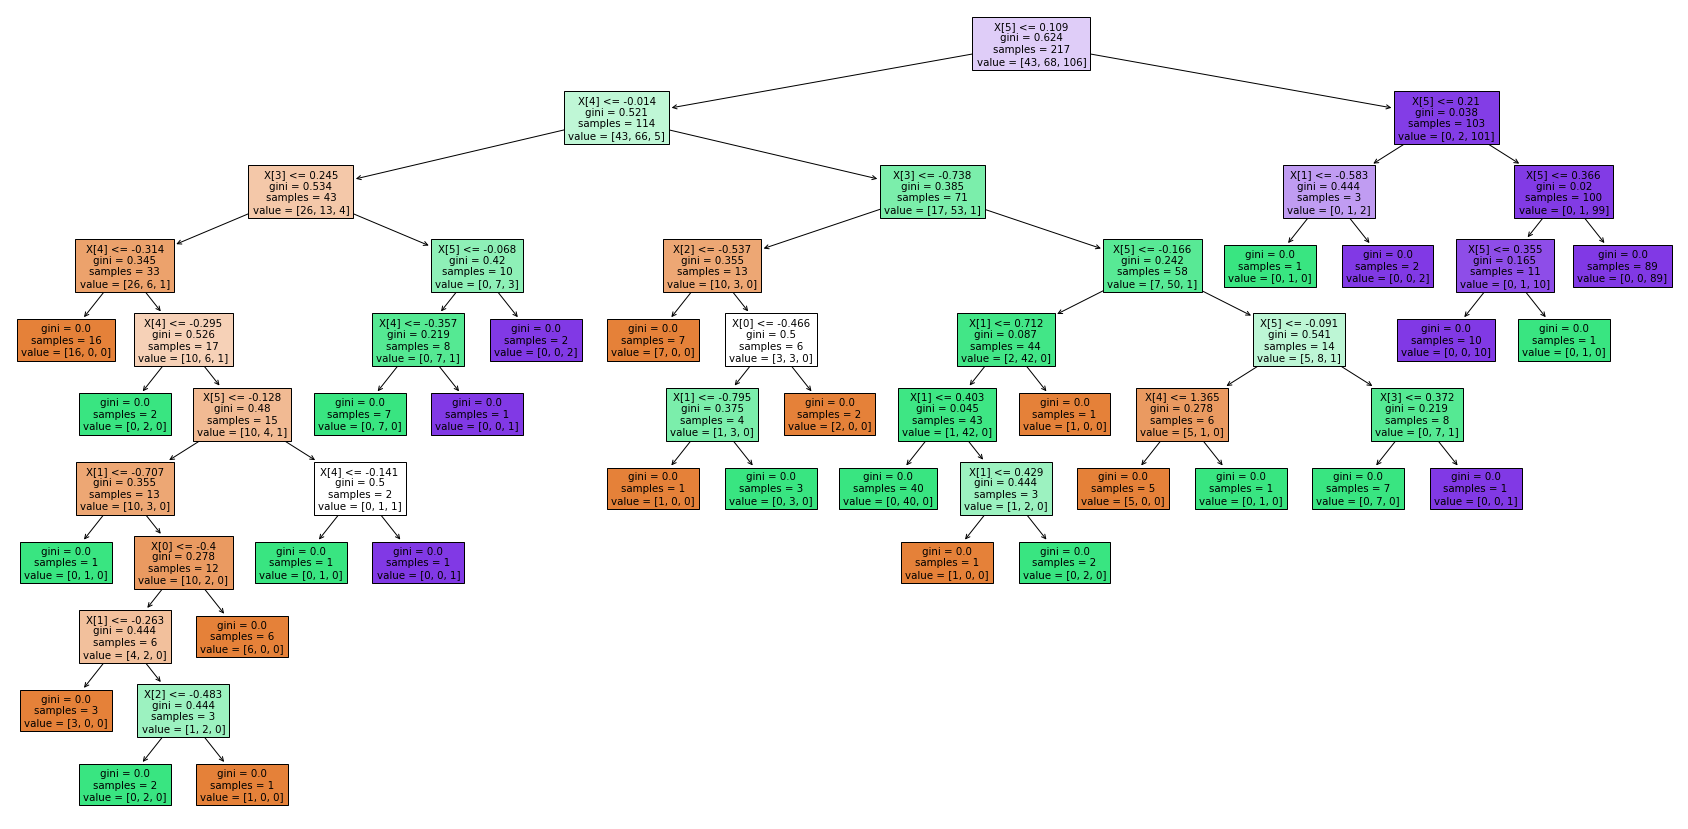

In [45]:
#Mostremos el árbol generado:
fig = plt.figure(figsize=(30,15))
_ = plot_tree(model, filled=True);

Balanced Accuracy Score: 0.7469362745098039  Accuracy Score: 0.7956989247311828


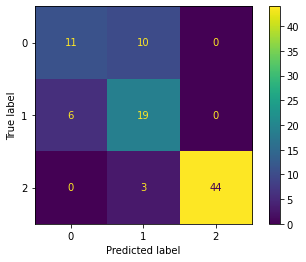

In [46]:
#Evaluemos el modelo:
bacc = balanced_accuracy_score(y_test, y_pred)
acc = accuracy_score(y_pred, y_test)
print(f'Balanced Accuracy Score: {bacc}  Accuracy Score: {acc}')
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_pred, y_test)).plot()
plt.show()

**Hasta aquí, lo que tenemos es el modelo entrenado "a lo bruto", veamos ahora que pasa si empleamos métodos de poda**

### Probemos primero metodos de pre-pruning

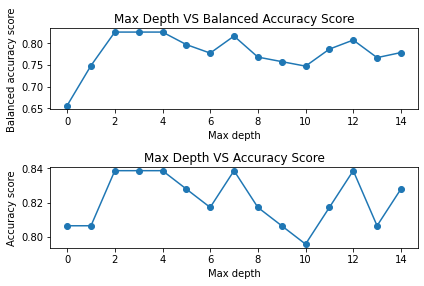

In [47]:
# Primero Empleemos metodos de pre-pruning:
depth, baccs, accs, models = list(), list(), list(), list()
for i in range(15):
    model = DecisionTreeClassifier(max_depth=i+1).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    bacc = balanced_accuracy_score(y_test, y_pred)
    acc = accuracy_score(y_pred, y_test)
    depth.append(i)
    baccs.append(bacc)
    accs.append(acc)
    models.append(model)
# Veamos los resultados:
fig, ax = plt.subplots(2, 1)
ax[0].plot(depth, baccs, marker='o')
ax[0].set_xlabel('Max depth')
ax[0].set_ylabel('Balanced accuracy score')
ax[0].set_title('Max Depth VS Balanced Accuracy Score')
ax[1].plot(depth, accs, marker='o')
ax[1].set_xlabel('Max depth')
ax[1].set_ylabel('Accuracy score')
ax[1].set_title('Max Depth VS Accuracy Score')
fig.tight_layout()

Balanced Accuracy Score: 0.8253676470588235  Accuracy Score: 0.8387096774193549


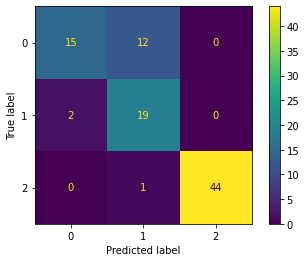

In [48]:
#Obtengamos el numero optimo de nodos en funcion del resultado anterior:
opt_model = DecisionTreeClassifier()
mx_dpth, mx_bacc, mx_acc = 0, 0, 0
for i in range(len(depth)):
    if baccs[i] > mx_bacc and accs[i] > mx_acc:
        opt_model = models[i]
        mx_bacc = baccs[i]
        mx_acc = accs[i]
        mx_dpth = depth[i]

y_pred = opt_model.predict(X_test)
bacc = balanced_accuracy_score(y_test, y_pred)
acc = accuracy_score(y_pred, y_test)
print(f'Balanced Accuracy Score: {bacc}  Accuracy Score: {acc}')
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_pred, y_test)).plot()
plt.show()

Vemos como la aplicación de los metodos de pre-pruning puede generar un resultado optimo y mas preciso que sin la aplicacion de estos métodos

### Pasemos ahora a los metodos de post-pruning

**Con un modelo nuevo:**

In [49]:
model = DecisionTreeClassifier()
path = model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

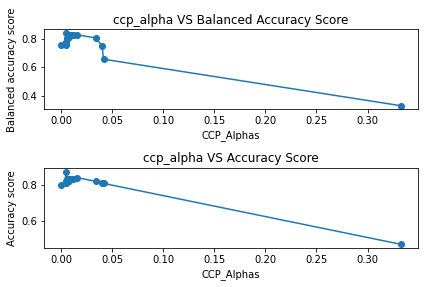

In [50]:
baccs, accs, models = list(), list(), list()
for ccp_alpha in ccp_alphas:
    model = DecisionTreeClassifier(ccp_alpha=ccp_alpha).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    bacc = balanced_accuracy_score(y_test, y_pred)
    acc = accuracy_score(y_pred, y_test)
    baccs.append(bacc)
    accs.append(acc)
    models.append(model)
# Veamos los resultados:
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, baccs, marker='o')
ax[0].set_xlabel('CCP_Alphas')
ax[0].set_ylabel('Balanced accuracy score')
ax[0].set_title('ccp_alpha VS Balanced Accuracy Score')
ax[1].plot(ccp_alphas, accs, marker='o')
ax[1].set_xlabel('CCP_Alphas')
ax[1].set_ylabel('Accuracy score')
ax[1].set_title('ccp_alpha VS Accuracy Score')
fig.tight_layout()

Balanced Accuracy Score: 0.8382352941176471  Accuracy Score: 0.8709677419354839


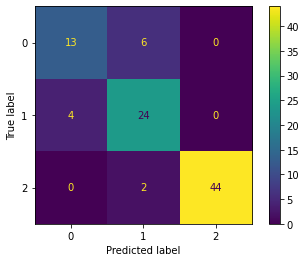

In [51]:
opt_model = DecisionTreeClassifier()
mx_bacc, mx_acc = 0, 0
for i in range(len(models)):
    if baccs[i] > mx_bacc and accs[i] > mx_acc:
        opt_model = models[i]
        mx_bacc = baccs[i]
        mx_acc = accs[i]

y_pred = opt_model.predict(X_test)
bacc = balanced_accuracy_score(y_test, y_pred)
acc = accuracy_score(y_pred, y_test)
print(f'Balanced Accuracy Score: {bacc}  Accuracy Score: {acc}')
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_pred, y_test)).plot()
plt.show()

Observando los resultados de ambos procesos, podemos concluir que los métodos de pre-pruning pueden llegar a ofrecernos resultados optimos pero siguen sin estar exentos del overfitting, sin embargo, los modelos a los que se les aplican métodos de post-pruning pueden llegar a ser mas precisos ya que se libran un poco mas del overfitting.

***

# Notas:

> Nota 1

# Bibliografia:

   * StackOverflow: 
   * ScikitLearn: https://scikit-learn.org
   * https://mljar.com/blog/visualize-decision-tree/